/Users/e175755/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	Train's auc: 0.779273	Test's auc: 0.435069
[40]	Train's auc: 0.783064	Test's auc: 0.432708
[60]	Train's auc: 0.785702	Test's auc: 0.427222
[80]	Train's auc: 0.78744	Test's auc: 0.413333
[100]	Train's auc: 0.787521	Test's auc: 0.41875
[120]	Train's auc: 0.787855	Test's auc: 0.414444
[140]	Train's auc: 0.790377	Test's auc: 0.419444
[160]	Train's auc: 0.791945	Test's auc: 0.415694
[180]	Train's auc: 0.794384	Test's auc: 0.431181
[200]	Train's auc: 0.796105	Test's auc: 0.416875
正解率 0.41687500000000005
スワーヴヨハン      15
テオファーニア      14
トランペットシェル    13
ヴィクトリオーソ     12
キョウワドライヴ     11
ヒロキング        10
フリーフロー        9
シェイドオヴペイル     8
ヤマニンパジャッソ     7
デルマベリル        6
テーオーバフェット     5
ミユキリバタリアン     4
トランクイッロ       3
キタノアティクス      2
リーヴスカーズ       1
Name: Horse_Name, dtype: int64


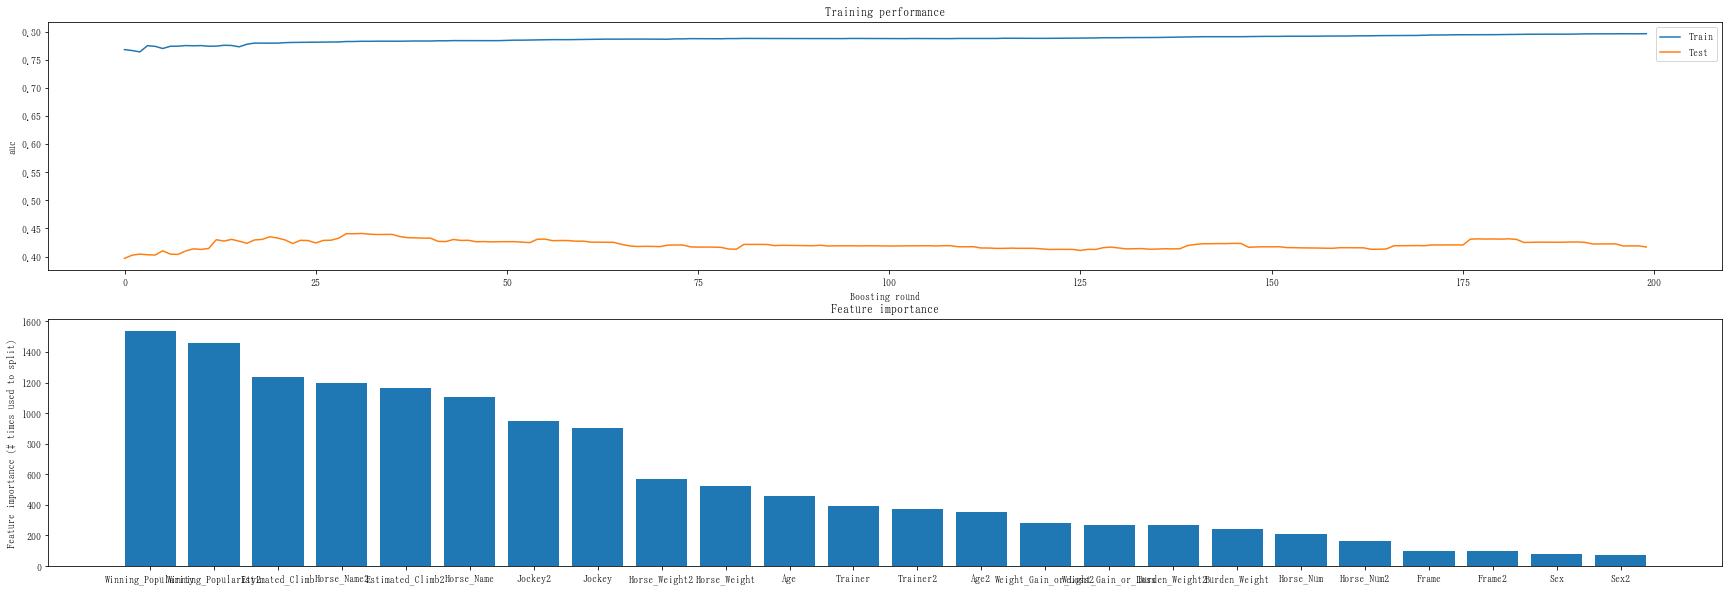

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import optuna
from functools import partial
from LightGBM import LightGBM
from LogisticReg import LogisticReg

# ハイパーパラメータ関数
def objective(trial, X_train, y_train, X_test, y_test):
    """最小化する目的関数"""
    # 調整するハイパーパラメータ
    params = {
        'learning_rate': trial.suggest_uniform('learning_rate', 1e-2, 1e0),
        'min_data_in_leaf': int(trial.suggest_int('min_data_in_leaf', 2, 64)),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 1e-1, 1e0),
        'num_leaves':int(trial.suggest_int('num_leaves', 2, 128)),
        'drop_date': trial.suggest_uniform('drop_date', 1e-2, 1e0),
    }
    #model = xgb.XGBClassifier(**params, boosting='dart', application='binary',metric='auc')
    lgb = LightGBM(**params)
    lgb.fit(X_train,y_train) # 学習させる
    pred = lgb.predict(X_test)  # テストデータからラベルを予測する
    preds = np.round(np.abs(pred))
    return f1_score(y_true=y_test, y_pred=preds, average='micro')#accuracy_score(y_test, model.predict(X_test))#最小化なので1から正解率を引く


if __name__ == "__main__":
    # インスタンス生成
    lgb = LightGBM()
    logi = LogisticReg()

    # csvを読み込む
    #keibaTrain = pd.read_csv("../data/scraping_datas/all2019.csv",sep=",", encoding="shift-jis")
    keibaTrain = pd.read_csv("../data/scraping_datas/train_preprocessing.csv",sep=",", encoding="shift-jis")
    keibaTest = pd.read_csv("../data/0111_R1_R4.csv",sep=",")#, encoding='shift-jis')

    category = ["Horse_Name", "Sex", "Jockey", "Trainer",
                "Horse_Name2", "Sex2", "Jockey2", "Trainer2"]
    #category = ["Horse_Name", "Sex_Age", "Jockey", "Trainer", "Wind_Direction", "Date", 
    #     "Horse_Name2", "Sex_Age2", "Jockey2", "Trainer2", "Wind_Direction2", "Date2"]

    # トレインデータの前処理
    #keibaTrain = lgb.preprocessing(keibaTrain.drop(columns="Unnamed: 0"))
    #keibaTrain.to_csv("../data/scraping_datas/train_preprocessing.csv", encoding="shift-jis")
    #keibaTrain = lgb.category_encode(keibaTrain.drop(columns="Unnamed: 0"), category)

    # テストデータの前処理
    keibaTest = lgb.preprocessing(keibaTest)
    keibaTest2 = keibaTest.copy() # rankingの表示用
    #keibaTest = lgb.category_encode(keibaTest, category, isTest=True)

    # カテゴリー処理
    keibaTrain, keibaTest = lgb.category_encode(keibaTrain.drop(columns="Unnamed: 0"), keibaTest, category)

    # データの準備
    X_train = keibaTrain.drop(columns="Win_or_Lose")
    y_train = keibaTrain["Win_or_Lose"]
    horse_Train = lgb.train_data(X_train, y_train)

    X_test = keibaTest.drop(columns="Win_or_Lose")
    y_test = keibaTest["Win_or_Lose"]
    horse_Test = lgb.test_data(X_test, y_test, horse_Train)

    #ハイパーパラメータ探索
    #optuna.logging.set_verbosity(optuna.logging.WARNING) # oputenaのログ出力停止
    #study = optuna.create_study(direction='maximize')  # 最適化のセッションを作る,minimize,maximize
    #study.optimize(lambda trial: objective(trial, horse_Train, horse_Test, X_test, y_test), n_trials=30)  # 最適化のセッションを作る
    #print("ベストF１",study.best_value)
    #print("ベストparam", study.best_params)

    # 学習する
    #lgb = LightGBM(**study.best_params)
    #lgb = LightGBM()
    lgb = LightGBM(learning_rate=0.09837612817007463, min_data_in_leaf=35, feature_fraction=0.6019194174984676, num_leaves=71, drop_date=0.5758799775332328)    
    lgb.fit(horse_Train, horse_Test, batch=200)
    #logi.fit(X_train, y_train)
    #predicted = logi.predict(X_test)
    predicted = lgb.predict(X_test)
    lgb.accuracy_rate(y_test, predicted)
    #logi.accuracy_matrix(X_test, y_test)
    # 順位を表示する
    lgb.ranking(keibaTest2, predicted)
    #logi.ranking(keibaTest2, predicted)
    lgb.plot_imp()

In [6]:
keibaTest

,Win_or_Lose,Frame,Horse_Num,Horse_Name,Sex,Age,Horse_Weight,Weight_Gain_or_Loss,Trainer,Jockey,...,Horse_Name2,Sex2,Age2,Horse_Weight2,Weight_Gain_or_Loss2,Trainer2,Jockey2,Burden_Weight2,Winning_Popularity2,Estimated_Climb2
0,1.0,1.0,1.0,-1.0,2,3.0,490.0,0.0,-1.0,-1.0,...,-1.0,1,3.0,490.0,0.0,-1.0,-1.0,53.0,14.0,0.0
1,0.0,1.0,2.0,-1.0,2,3.0,490.0,0.0,-1.0,-1.0,...,-1.0,1,3.0,490.0,0.0,-1.0,-1.0,56.0,5.0,0.0
2,1.0,1.0,1.0,-1.0,2,3.0,490.0,0.0,-1.0,-1.0,...,-1.0,1,3.0,506.0,0.0,-1.0,-1.0,56.0,10.0,0.0
3,0.0,2.0,3.0,-1.0,2,3.0,506.0,0.0,-1.0,-1.0,...,-1.0,1,3.0,490.0,0.0,-1.0,-1.0,56.0,5.0,0.0
4,1.0,1.0,1.0,-1.0,2,3.0,490.0,0.0,-1.0,-1.0,...,-1.0,1,3.0,490.0,0.0,-1.0,196.0,56.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,8.0,15.0,-1.0,2,3.0,552.0,0.0,-1.0,-1.0,...,-1.0,1,3.0,464.0,0.0,-1.0,-1.0,56.0,15.0,0.0
236,1.0,7.0,14.0,-1.0,2,3.0,464.0,0.0,-1.0,-1.0,...,-1.0,1,3.0,498.0,0.0,-1.0,161.0,56.0,3.0,0.0
237,0.0,8.0,16.0,-1.0,2,3.0,498.0,0.0,-1.0,161.0,...,-1.0,1,3.0,464.0,0.0,-1.0,-1.0,56.0,15.0,0.0
238,1.0,8.0,15.0,-1.0,2,3.0,552.0,0.0,-1.0,-1.0,...,-1.0,1,3.0,498.0,0.0,-1.0,161.0,56.0,3.0,0.0


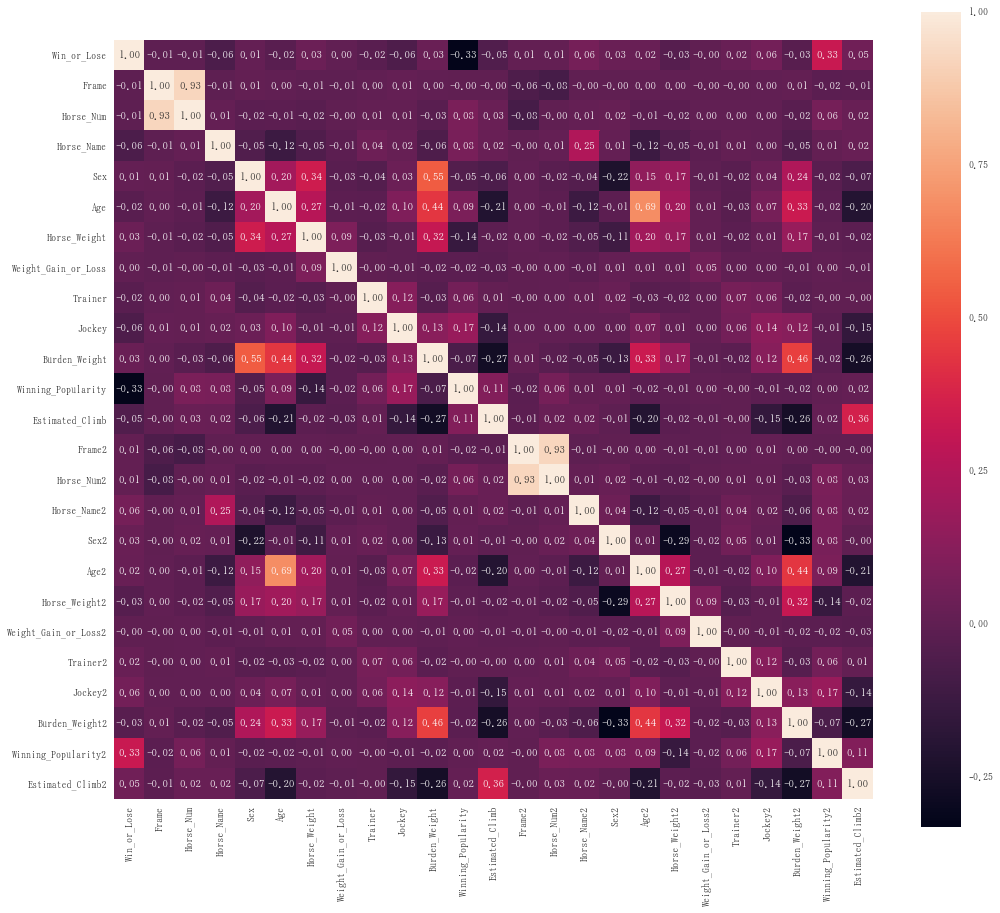

In [13]:
import matplotlib
#https://qiita.com/u1and0/items/3b4d0f3e5514c9893d89 日本語フォントを使用するための
matplotlib.font_manager._rebuild()#chashのreload
#相関行列
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#size_mapping = {'navigation': 0, 'canceled': 1}
#df['着順'] = df['着順'].map(size_mapping)

cols = ["Win_or_Lose", "Frame", "Horse_Num", "Horse_Name", "Sex", "Age", "Horse_Weight", "Weight_Gain_or_Loss", "Trainer",
                     "Jockey","Burden_Weight", "Winning_Popularity", "Estimated_Climb", "Frame2", "Horse_Num2", "Horse_Name2", "Sex2","Age2",
                     "Horse_Weight2", "Weight_Gain_or_Loss2", "Trainer2", "Jockey2","Burden_Weight2", "Winning_Popularity2", "Estimated_Climb2"]

cm = np.corrcoef(keibaTrain[cols].values.T)
#sns.set(font_scale=1.5)
plt.subplots(figsize = (17,15))

sns.set(font=['IPAMincho'])#日本語フォント
sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 11},
                 yticklabels=cols,
                 xticklabels=cols)

#plt.tight_layout()
# plt.savefig('images/10_04.png', dpi=300)
#plt.show()
#df.head()

In [23]:
lgb.plot_imp()

AttributeError: 'LightGBM' object has no attribute 'plot_imp'

In [25]:
print(dir(lgb))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'accuracy_rate', 'category_encode', 'fit', 'model', 'parameters', 'predict', 'preprocessing', 'ranking', 'test_data', 'train_data']
